# Multi Layer Perceptron NLP Model by Bengio, Part 1

This is an implementation of a character level NLP model, motivated by [Bengio et al.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) paper, based on Andrej Karpathy's [Makemore](https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3) lectures.

<br>
<br>
<figure align="center">
    <img src="./images/bengio_2003_neural_architecture.png" width="500">
    <figcaption>Bengio et al.'s neural model.</figcaption>
</figure>

, where $w_t$ is the t-th word, and $w_i^j = \left(w_i, w_{i+1}, \ldots, w_{j-1}. w_j\right)$ is a sequence of words from $i$ to $j$. Since in this example we will teach a neural network to generate names based on examples, instead of using words, we use characters.

## Input to the Model

The input to the model is a sequence of n-characters (we use 3 in the code). These characters are converted into a 2D embedding space using a look-up-table C. LUT is part of the nn model, so the weights for the LUT are learned. The rationale for using a learned embedding space is for the model to be able to generalize better, especially when it comes across input that is has not seen previously.

## Output from the Model 

For each combination of 3 input characters, the model outputs a probability distribution for the 27 letters from the alphabet. Using the probability distribution we can sample letters.

## Loss Function

We need a way of measuring how well the model is doing so that the deep-learning model can learn based on the given examples. In order to do so, we need a loss function. We start by defining the likelihood function. Likelihood function is the joint probability of the observed data viewed as a function of the parameters of a statistical model (source: [Wikipedia](https://en.wikipedia.org/wiki/Likelihood_function)). In statistics, maximum likelihood estimation is a method of estimating the parameters of an assumed probability distribution, given observed data. For a set of independent and identically distributed points $X = \{x_1, x_2,..., x_n\}$, the likelihood is defined as follows:

$$\mathcal{L}(\theta|x)=p(X|\theta)=\prod_{n=1}^{N}p(x_n|\theta)$$

$\mathcal{L}(\theta|x)$ is the likelihood function, $\theta$ are the model parameters and $x$ are the observations. We want to maximize the likelihood of the data with respect to the parameters. In other words, we want to maximize the likelihood, by tweaking the parameters $\theta$, that the model produces the observed data. Since we have many bigrams, we want to maximize the likelihood over all of them, which leads to a product over all of the probabilities. Since the probability for each individual observation is between $[0...1]$, multiplying these together leads to a small number and numerical instabilities. Therefore, we want to maximize the log-likelihood. Since $log(a \cdot b)=log(a)+log(b)$, we get:

$$log\left(\mathcal{L}(\theta|x)\right)=\sum_{n=1}^{N}log\left(p(x_n|\theta)\right)$$

The way we train deep-learning networks is by minizing a loss function. Maximizing the log-likelihood is equivalent to minimizing the negative log-likelihood, and in order for the results to be comparable regardless the number of data points we are using, we normalize the negative log-likelihood by dividing it with the number of data points we have. Therefore, our loss function is:

$$-\dfrac{1}{N}\sum_{n=1}^{N}log\left(p(x_n|\theta)\right)$$

In [1]:
import urllib.request
import torch
import torch.nn as nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Url to the file containing over 30k names
url_source = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"

text = str('')

# Read to a variable, line by line
for line in urllib.request.urlopen(url_source):
    text += line.decode('utf-8')

In [3]:
# Split the file to lines and show the first 10 lines
words = text.splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
# Create the dictionaries to map characters to integers and vice versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(f"{stoi=}")
print(f"{itos=}")

stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Explanation of the Model

This part explains how the model works, later on it will be rewritten for training purposes.

In [5]:
# Build the dataset
block_size = 3
X, Y = [], []

for w in words[:3]:
    print(w)
    # This creates a list, filled with zeros:, that has the length defined by the variable block_size
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .


In [6]:
# X are the learning samples, and Y are the labels.
# Y = f(X), where f() represents the neural-network.
print(f"{X.shape=}, {X.dtype=}")
print(f"{Y.shape=}, {Y.dtype=}")

X.shape=torch.Size([16, 3]), X.dtype=torch.int64
Y.shape=torch.Size([16]), Y.dtype=torch.int64


In [7]:
# A look-up-table for the character encodings, encodes each character into a 2D space.
# 27 is the size of the input-space, i.e. the number of letters.
# 2 is the size of the encoded output-space.
# This is the input layer to the network. Weights of the C-mapping will be learned by the model.
C = torch.randn(27, 2)

In [8]:
print(f"{X.shape=}")
print(f"{C[X].shape=}")

X.shape=torch.Size([16, 3])
C[X].shape=torch.Size([16, 3, 2])


In [9]:
# We need to reshape the input (embedded space) space so that it can be connected to the
# first hidden layer. The shape needs to be (batch_size, 6).
emb = C[X]
print(f"Shape of the input: {emb.shape=}")
print(f"Shape of the input, after reshaping: {emb.view(-1, 6).shape=}")

Shape of the input: emb.shape=torch.Size([16, 3, 2])
Shape of the input, after reshaping: emb.view(-1, 6).shape=torch.Size([16, 6])


In [10]:
# Building the network, first hidden layer.
# We're feeding 3-characters into the model and each character is encoded into a 2D space, therefore
# the input to the network is 3x2 = 6
W1 = torch.randn((6, 100)) # Weights of the first layer
b1 = torch.randn(1, 100) # Bias terms of the first layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [11]:
# Output layer
W2 = torch.randn((100, 27)) # Weights of the output layer
b2 = torch.randn(1, 27) # Bias terms of the output layer

In [12]:
# Here we calculate the logits, corresponding probability distributions, and the loss based on the labels
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(16), Y].log().mean()

## Training the Model

In [13]:
block_size = 3 # how many characters we use in order to predict the next one

def build_dataset(words_in, block_size_in=3):
    
    X, Y = [], []

    for w in words_in:
        # This creates a list, filled with zeros:, that has the length defined by the variable block_size
        context = [0] * block_size_in
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

In [14]:
embedding_size = 10
hidden_layer_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embedding_size), generator=g)
W1 = torch.randn((embedding_size*block_size, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [15]:
losses = np.array([])

In [16]:
batch_size = 128

for k in range(30000):
    
    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    #--- FORWARD PASS ---
    emb = C[Xtr[ix]]
    
    # Linear layer
    #---------------------------------------------------------------------------
    z1 = emb.view(-1, W1.shape[0]) @ W1 + b1
    #---------------------------------------------------------------------------
    
    # Non-linearity/activation
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    # Instead of implementing the loss function manually (negative log likelihood), we use
    # PyTorch's internal function 'cross_entropy' as it is more efficient.
    loss = torch.nn.functional.cross_entropy(logits, Ytr[ix])
    losses = np.append(losses, loss.log10().item())

    #--- BACKWARD PASS ---
    # Reset the gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate
    lr = 0.1 if k < 20000 else 0.005

    # update the weights
    for p in parameters:
        p.data += -lr * p.grad

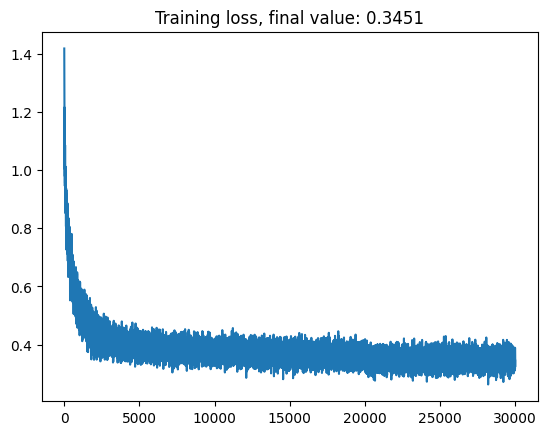

In [17]:
plt.plot(losses)
plt.title(f'Training loss, final value: {losses[-1].item():.4f}')
plt.show()

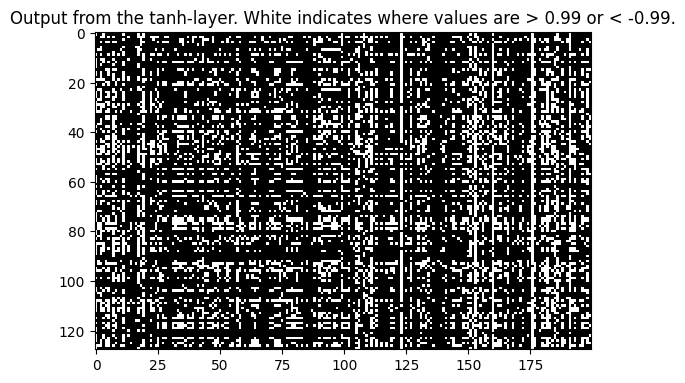

In [18]:
# Here we verify if we have dead neurons. If the output from tanh is >0.99 or <-0.99, then
# the gradients vanish. In the image below, if we have a column drawn in white, it means that we have a dead neuron.
plt.imshow(a1.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title("Output from the tanh-layer. White indicates where values are > 0.99 or < -0.99.")
plt.show()

In [19]:
# A function to evaluate the loss
@torch.no_grad()
def calc_loss(X_in, Y_in):

    emb = C[X_in]
    z1 = emb.view(-1, W1.shape[0]) @ W1 + b1
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    return torch.nn.functional.cross_entropy(logits, Y_in)

print(f"Training loss: {calc_loss(Xtr, Ytr)}")
print(f"Validation loss: {calc_loss(Xval, Yval)}")

Training loss: 2.2372636795043945
Validation loss: 2.248884916305542


In [20]:
# Sample names from the model
for i in range(10):
    chars = [0] * 3
    while True:

        emb = C[torch.tensor(chars)]
        h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
        logits = h @ W2 + b2
        counts = logits.exp()
        prob = counts / counts.sum(1, keepdim=True)

        new_char = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
        if new_char == 0:
            break
        chars = chars[1:] + [new_char]
        print(itos[new_char], end="")
    print("")

aymidah
rakuce
avaxthayleygh
james
tahlanas
frelyah
adbri
rissa
ara
ada
